In [1]:
import numpy as np
import pandas as pd
from quantbullet.preprocessing import FlatRampTransformer
from sklearn.preprocessing import OneHotEncoder
from quantbullet.linear_product_model import LinearProductModelToolkit, LinearProductRegressorBCD
from quantbullet.parametic_model import AsymQuadModel, InterpolatedModel
from quantbullet.parametic_model.utils import compare_models
from quantbullet.linear_product_model.datacontainer import ProductModelDataContainer

In [2]:
np.random.seed(42)
n_samples = int( 10e4 )
df = pd.DataFrame({
    'x1': 10 + 3 * np.random.randn(n_samples),
    'x2': 20 + 3 * np.random.randn(n_samples),
    'x3': np.random.choice([0, 1, 2], size=n_samples, p=[0.25, 0.25, 0.5])
})

df['x3'] = df['x3'].astype('category')

df['y'] = np.cos( df['x1'] / 3 ) + np.sin(df['x2'] / 5) + \
    np.random.randn(n_samples) * 0.5 + \
    np.random.normal(loc = df['x3'].cat.codes, scale=0.5) + 10

feature_config = {
    'x1': FlatRampTransformer(
        knots = list( np.arange( 4, 16, 1 ) ),
        include_bias=True
    ),
    'x2': FlatRampTransformer(
        knots = list( np.arange( 14, 26, 1 ) ),
        include_bias=True
    ),
    'x3': OneHotEncoder( drop=None )
}

tk = LinearProductModelToolkit( feature_config ).fit( df )
train_df = tk.get_train_df( df )

In [3]:
dcontainer = ProductModelDataContainer( df, train_df, response=df['y'], feature_groups=tk.feature_groups )

In [4]:
model = LinearProductRegressorBCD()

In [6]:
model.fit( dcontainer, feature_groups=tk.feature_groups, n_iterations=20, early_stopping_rounds=5, cache_qr_decomp=False, ftol=1e-8, offset_y=0 )

Iteration 1/20, Loss: 5.025260e-01
Iteration 2/20, Loss: 5.015175e-01
Iteration 3/20, Loss: 5.015175e-01
Iteration 4/20, Loss: 5.015175e-01
Iteration 5/20, Loss: 5.015175e-01
Iteration 6/20, Loss: 5.015175e-01
Iteration 7/20, Loss: 5.015175e-01
Converged at iteration 7 with Loss: 5.0152e-01


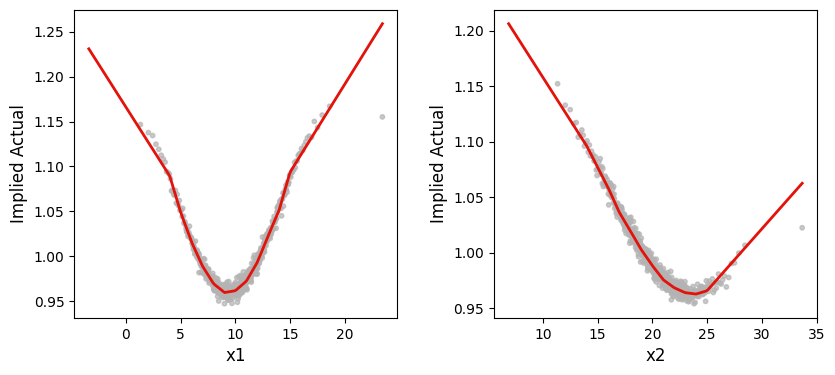

In [7]:
fig, axes, caches = tk.plot_discretized_implied_errors( model, dcontainer, sample_frac=1, n_quantile_groups=500, method='bin' )

In [8]:
feature_name = 'x1'
linear_pred = tk.get_single_feature_pred_given_values( feature_name=feature_name, feature_values=caches[feature_name].agg_df['feature_bin_right'], model=model )
x1_implied_actuals = caches[feature_name].agg_df['implied_actual_mean']
x1 = caches[feature_name].agg_df['feature_bin_right']

In [9]:
x1_model = AsymQuadModel( allow_extrapolation=False ).fit( x1, x1_implied_actuals )
x1_model.model_name = "x1-AsymQuadModel"

linear_model = InterpolatedModel().fit( x1, linear_pred )
linear_model.model_name = "x1-LinearModel"

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Model Comparison'}, xlabel='x', ylabel='y'>)

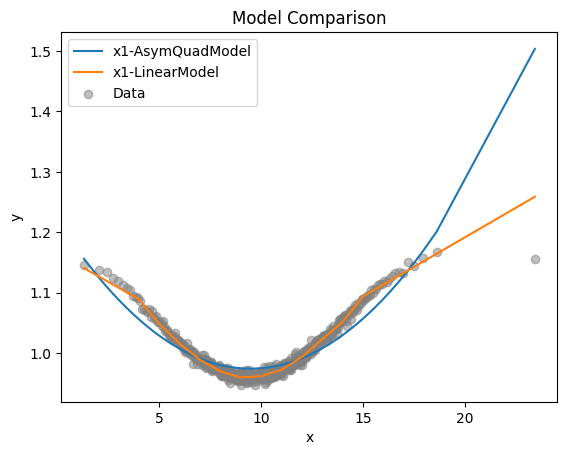

In [10]:
compare_models( models=[x1_model, linear_model], x=x1, y=x1_implied_actuals )

In [11]:
feature_name = 'x2'
linear_pred = tk.get_single_feature_pred_given_values( feature_name=feature_name, feature_values=caches[feature_name].agg_df['feature_bin_right'], model=model )
x2_implied_actuals = caches[feature_name].agg_df['implied_actual_mean']
x2 = caches[feature_name].agg_df['feature_bin_right']

In [12]:
x2_model = AsymQuadModel( allow_extrapolation=False ).fit( x2, x2_implied_actuals )
x2_model.model_name = "x2-AsymQuadModel"

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Model Comparison'}, xlabel='x', ylabel='y'>)

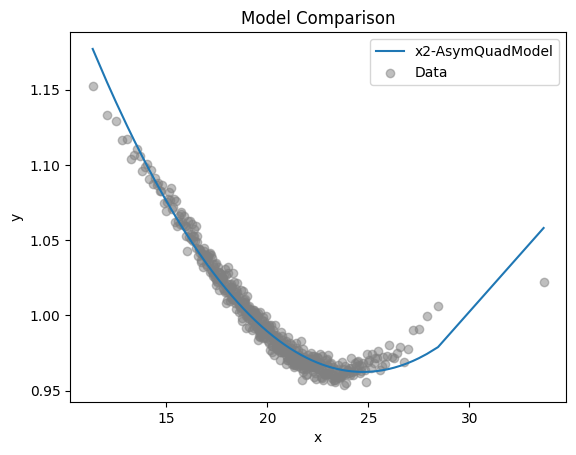

In [13]:
compare_models( models=[x2_model], x=x2, y=x2_implied_actuals )

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: xlabel='x3', ylabel='Implied Actual'>, <Axes: >, <Axes: >],
       dtype=object))

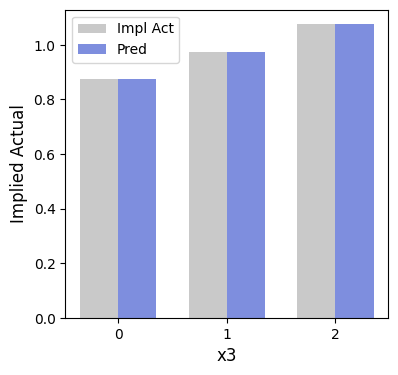

In [14]:
tk.plot_categorical_plots( model, dcontainer, sample_frac=1, method='bin')

## Use Parametric Models as Model Components

In [2]:
from quantbullet.linear_product_model import ComponentManager, ComponentConfig, ComponentRegistry

In [16]:
x1_component = ComponentConfig(
    class_name = 'AsymQuadModel',
    args = x1_model.to_dict(),
)

manager = ComponentManager( ComponentRegistry( label='Test' ) )
manager.add_component( "x1", x1_component )

manager.to_json( r"test-model-components.json" )

In [17]:
manager.build_all_models()

## Test the support for Model Components

In [15]:
import numpy as np
import pandas as pd

from quantbullet.linear_product_model import (
    ComponentManager,
    ComponentConfig,
    ComponentRegistry,
    LinearProductModelToolkit,
    LinearProductRegressorBCD,
)
from quantbullet.linear_product_model.datacontainer import ProductModelDataContainer
from quantbullet.preprocessing import FlatRampTransformer
from quantbullet.parametic_model import AsymQuadModel, InterpolatedModel
from quantbullet.parametic_model.utils import compare_models
from sklearn.preprocessing import OneHotEncoder

In [16]:
component_manager = ComponentManager.from_json( r"./test-model-components.json" )

In [17]:
component_manager.build_all_models()

In [18]:
np.random.seed(42)
n_samples = int( 10e4 )
df = pd.DataFrame({
    'x1': 10 + 3 * np.random.randn(n_samples),
    'x2': 20 + 3 * np.random.randn(n_samples),
    'x3': np.random.choice([0, 1, 2], size=n_samples, p=[0.25, 0.25, 0.5])
})

df['x3'] = df['x3'].astype('category')

df['y'] = np.cos( df['x1'] / 3 ) + np.sin(df['x2'] / 5) + \
    np.random.randn(n_samples) * 0.5 + \
    np.random.normal(loc = df['x3'].cat.codes, scale=0.5) + 10

feature_config = {
    'x1': FlatRampTransformer(
        knots = list( np.arange( 4, 16, 1 ) ),
        include_bias=True
    ),
    'x2': FlatRampTransformer(
        knots = list( np.arange( 14, 26, 1 ) ),
        include_bias=True
    ),
    'x3': OneHotEncoder( drop=None )
}

tk = LinearProductModelToolkit( feature_config ).fit( df )
train_df = tk.get_train_df( df )

In [19]:
dcontainer = ProductModelDataContainer( df, train_df, response=df['y'], feature_groups=tk.feature_groups )

In [20]:
model = LinearProductRegressorBCD()

In [21]:
model.fit( dcontainer, feature_groups=tk.feature_groups, submodels = component_manager.models, n_iterations=20, early_stopping_rounds=5, cache_qr_decomp=False, ftol=1e-8, offset_y=0 )

Iteration 1/20, Loss: 5.236007e-01
Iteration 2/20, Loss: 5.232408e-01
Iteration 3/20, Loss: 5.232408e-01
Iteration 4/20, Loss: 5.232408e-01
Iteration 5/20, Loss: 5.232408e-01
Iteration 6/20, Loss: 5.232408e-01
Converged at iteration 6 with Loss: 5.2324e-01


(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: xlabel='x1', ylabel='Implied Actual'>,
        <Axes: xlabel='x2', ylabel='Implied Actual'>, <Axes: >],
       dtype=object),
 {'x1': ImpliedActualDataCache(feature='x1', agg_df=                     feature_bin  implied_actual_mean  count  \
  0   (-3.3979999999999997, 2.996]             1.131570   1000   
  1                  (2.996, 3.85]             1.101634   1000   
  2                  (3.85, 4.358]             1.077764   1000   
  3                 (4.358, 4.735]             1.064731   1000   
  4                  (4.735, 5.07]             1.053672   1000   
  ..                           ...                  ...    ...   
  95              (14.952, 15.264]             1.091195   1000   
  96              (15.264, 15.648]             1.101406   1000   
  97              (15.648, 16.164]             1.114700   1000   
  98              (16.164, 16.968]             1.128858   1000   
  99              (16.968, 23.437]            

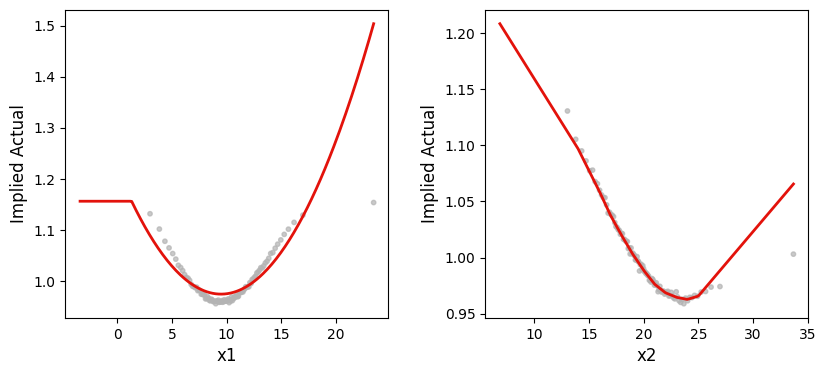

In [23]:
tk.plot_discretized_implied_errors( model, dcontainer )

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: xlabel='x3', ylabel='Implied Actual'>, <Axes: >, <Axes: >],
       dtype=object))

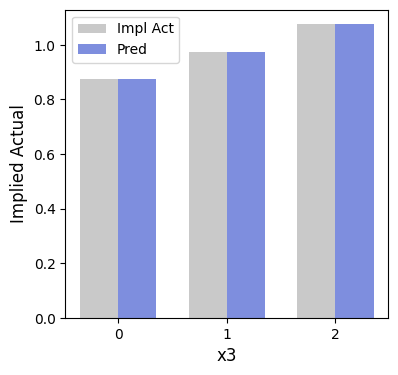

In [24]:
tk.plot_categorical_plots( model, dcontainer )